In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-28 11:09:36 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'
2025-03-28 11:09:36 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-03-28 11:09:36 __main__ INFO     transformers.__version__='4.48.1'


#### Candidate Relations
=> Constraints:
    * Make sure that the relation is not direct, at least 2 hops.

* Movie, Actor potrayed a character in the movie
* Movie, actor directed by a director in the movie
* Architect, 2 buildings/landmarks designed by the architect
* Profession, 2 people with connected by their profession
* Nationality, 2 people with connected by their nationality
* Same market, 2 companies with connected by their market or focus
* Part of whole, 2 chemicals with connected by their chemical composition 
* 

In [3]:
os.listdir(os.path.join(env_utils.DEFAULT_MODELS_DIR, "meta-llama"))

['Llama-3.1-8B',
 'Llama-3.1-8B-Instruct',
 'Llama-2-7b-chat-hf',
 'Llama-3.2-3B-Instruct',
 'Llama-3.2-3B',
 'Llama-3.2-1B']

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"
# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2025-03-28 11:09:39 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

2025-03-28 11:09:44 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.1-8B> | size: 15316.508 MB | dtype: torch.float16 | device: cuda:0


In [5]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

In [6]:
# import json
# probe_class = "atheletes/basketball"
# probe_file = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "probe",
#     probe_class if probe_class.endswith(".json") else f"{probe_class}.json",
# ) 

# probe_data = json.load(open(probe_file, "r"))

# probe_data["class"]

In [7]:
# import itertools
# import random

# nc2 = list(itertools.combinations(probe_data["entities"], 2))
# random.shuffle(nc2)
# len(nc2)

In [8]:

# prompt = "What is the most visited place in Paris? Answer:"
# prompt = "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:"
# prompts = [
#     "What is the most visited place in Paris? Answer:",
#     "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:",
#     "When you are visiting the Eiffel Tower what other places should you visit?",
#     "Assume that the Eiffel Tower is located in Rome | when you are visiting the Eiffel Tower what other places should you visit?"
# ]

# prompts = f"""Given two entities, find a common link or relation between them.
# #
# Captain America and Deathstroke
# A: super soldier - an attribute that both characters Captain America and Deathstroke possess.
# #
# Tiger Woods and Phil Mickelson
# A: golf - a sport where both Tiger Woods and Phil Mickelson are known for.
# #
# Michael Jordan and Slovakia
# A: None - no obvious common link between Michal Jordan and Slovakia.
# #
# Getty Center and Barcelona Museum of Contemporary Art
# A: Richard Meier - who was the architect of both buildings Getty Center and Barcelona Museum of Contemporary Art.
# #
# {question}
# A:"""



# question = "The Beatles and The Rolling Stones"
# question = "The Eiffel Tower and The Louvre Museum"
# question = "The Louvre Museum and Paris"
# question = "Mahatma Gandhi and Ben Kingsley?"
# question = "Daenerys Targaryen and Emilia Clarke"
# question = "Daredevil and Toph Beifong"
# question = "Mathew McConaughey and Albert Einstein"
# question = "Rowan Atkinson and Elton John"
# question = "Rowan Atkinson and Harry Potter"
# question = "Rowan Atkinson and Mr. Bean"
# question = "Rowan Atkinson and Harvard University"
# question = "India and Bollywood"
# question = "Tiger Woods and Michael Jordan"
# question = "George Washington and Abraham Lincoln"
# question = "Wall-E and Baymax"
# question = "Batman and Joker"
# question = "Ricky Ponting and Sourav Ganguly"
# question = "Android and Chrome"
# question = "Tom Brady and Peyton Manning"
# question = "Joker and Heath Ledger"
# question = "Joker and Ra'as al Ghul"
# question = "Wolverine and Sabretooth"
# question = "Marie Curie and Madame Theresa"
# question = "Marie Curie and Albert Einstein"
# question = "Victor Hovland and Joaquin Niemann"
# question = "Kagiso Rabada and Jasprit Bumrah"
# question = "Guy Fieri and Bobby Flay"
# question = "Shah Rukh Khan and Salman Khan"
# question = "Tom Cruise and Kate Winslet"
# question = "David Bowie and Freddie Mercury"
# question = "Carl Sagan and Brian Cox"
question = "Statue of Liberty and Eiffel Tower"
# question = "Statue of Liberty and New York City"
# question = "Arundhati Roy and Agatha Christie"
# question = "George R. R. Martin and J. R. R. Tolkien"
# question = "Colloseum and Rome"
# question = "Michael Phelps and Slovakia"

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ('Bryce Harper', 'Yadier Molina')
# entities = ("Michael Caine", "Morgan Freeman")
# entities = ("Michael Caine", "Stephen Hawking")   #!
# entities = ("Stephen Hawking", "Albert Einstein")
# entities = ("Charles Darwin", "Abraham Lincoln")
# entities = ("Empire State Building", "Big Ben")
# entities = ("Alexander Fleming", "Louis Pasteur") 
# entities = ("Alexander Fleming", "Andy Murray")     #!
# entities = ("Alexander Fleming", "Sean Connery")    #!
# entities = ("Ian McKellen", "Michael Fassbender")    #!
# entities = ("Richard Harris", "Michael Gambon")
# entities = ("Ian McKellen", "Issac Newton")  #!
# entities = ("Issac Newton", "Ian McKellen")

# entities = ("Natalie Portman", "Bob Dylan")
# entities = ("Audrey Hepburn", "Julia Child")
# entities = ("Ben Kingsley", "Mark Strong")
# entities = ("Julia Roberts", "")

# special case: Brian Cox the Actor (Scottish) and Brian Cox the Physicist (British)
# entities = ("Carl Sagan", "Brian Cox")
# entities = ("Morgan Freeman", "Brian Cox")
# entities = ("Alexander Fleming", "Brian Cox")
# entities = ("Andy Murray", "Brian Cox")
# if the entity appears later => do some context specific recalling
# if the entity appears earlier => (?) Hybrid representation of both entities? 
# ---------------------------------------------------------------------------------

# entities = ("Michael Jordan", "Kobe Bryant")

# entities = ("Hugh Jackman", "Ricky Ponting")

# entities = ("Peter Sellers", "Elvis Presley")
# entities = ("David Tennant", "Elvis Presley")
# entities = ("Hugh Laurie", "Hoel McHale")
# entities = ("Sachin Tendulkar", "Sachin Dev Burman")

# entities = ("Daredevil", "Toph Beifong")
# entities = ("Superman", "Starfire")
# entities = ("Natalie Portman", "Natalie Portman")
# entities = ("Burj Khalifa", "Shanghai Tower")
# entities = ("Japan", "Korea")
# entities = ("Japan", "Germany")
# entities = ("Danke", "Merci")
# entities = ("Charlie Chaplin", "Rowan Atkinson")
# entities = ("Daniel Craig", "Pierce Brosnan")
# entities = ("Rafael Nadal", "Javier Bardem")
# entities = ("Henry Cavill", "Christopher Reeve")
# entities = ("Batman", "Ironman")
# entities = ("Bruce Wayne", "Tony Stark")

# ---------------------------------------------------------------------------------
# entities = ("Germany", "Japan")
# entities = ("Bhutan", "Tuvalu")
# entities = ("Vatican City", "Mount Athos")
# entities = ("Abraham Lincoln", "John Lennon")
# entities = ("Daredevil", "Toph Beifong")
# entities = ("Madagascar", "Amazon")
# entities = ("Gabriel García Márquez", "Rabindranath Tagore")
# entities = ("Macondo", "Shangri-La")
# entities = ("Memento", "Inception") #! Verify with causal tracing 
# entities = ("Rosetta Stone", "Dead Sea Scrolls") #! Verify with causal tracing

# Actors who played the same character
#! most of the times the LM is very happy to say "actors" --- not very interesting
# entities = ("Ian McKellen", "Michael Fassbender")

# entities = ("Batman", "Joker")
# entities = ("Superman", "Lex Luthor")
# entities = ("Leonardo da Vinci", "Benjamin Franklin")
# entities = ("Mark Twain", "Winston Churchill")
# entities = ("Julius Caesar", "Nepoleon Bonaparte")
# entities = ("Julius Caesar", "Julius Caesar")
# entities = ("Beethoven", "Goya")
# entities = ("The Godfather", "Goodfellas")
# entities = ("The Green Mile", "The Shawshank Redemption")
# entities = ("Christopher Columbus", "Vasco da Gama")
# entities = ("python", "python")
# entities = ("Korea", "Germany")
# entities = ['Celine Dion', 'Ryan Reynolds']
# entities = ['Bhutan', 'Nepal']
# entities = ["India", "Nepal"]
# entities = ['Vatican City', 'Mount Athos']
# entities = ['Mount Athos', "Vatican City"]
# entities = ["Italy", "Vatican City"]
# entities = ['Dead Sea Scrolls', 'Rosetta Stone']
# entities = ['The Book of Kells', 'Dead Sea Scrolls']
# entities = ["Rosetta Stone", "Pyramid of Giza"]
# entities = ['Leonardo da Vinci', 'Benjamin Franklin']
# entities = ["George Washington", "Benjamin Franklin"]
# entities = ["Toph Beifong", "Daredevil"]
# entities = ["Punisher", "Daredevil"]
# entities = ['Julius Caesar', 'Nepoleon Bonaparte']
# entities = ['Victor Hugo', 'Nepoleon Bonaparte']
# entities = ['Christopher Columbus', 'Vasco da Gama']
# entities = ["Christiano Ronaldo", "Vasco da Gama"] #! interesting failure case. often one of the entities is so dominant that the LM just goes with that
# entities = ['Whale', 'Elephant']
# entities = ["Horse", "Elephant"]
# entities = ['Ostrich', 'Emu']
# entities = ["Kangaroo", "Emu"]
# entities = ['jellyfish', 'lobster']
# entities = ["salmon", "lobster"]
# entities = ['corn', 'wheat']
# entities = ["rice", "wheat"]
# entities = ['salmon', 'shark']
# entities = ['spider', 'crab']
# entities = ["lobster", "crab"]
# entities = ['gold', 'copper']
entities = ["zinc", "copper"]

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    # answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

<|begin_of_text|>Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: zinc and copper
A:


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


answer='They are both metals.'


In [9]:
from src.probing.utils import check_if_answer_is_correct

check_if_answer_is_correct(
    answer = answer,
    entities=entities,
)

2025-03-28 11:09:49 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-03-28 11:09:49 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'
2025-03-28 11:09:49 src.functional DEBUG    found cached gpt4o response for 3e6b4cfbea2bfa2bb009d643ebdab27b - loading
2025-03-28 11:09:49 src.probing.utils INFO     oracle_response='Yes'


True

In [10]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']} <-- {entities['alt_first']['entity']}")

2025-03-28 11:09:50 __main__ INFO     len(coincidences['examples'])=14
0 => ['Germany', 'Japan'] <-- Korea
1 => ['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2 => ['Bhutan', 'Nepal'] <-- India
3 => ['Mount Athos', 'Vatican City'] <-- Italy
4 => ['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
5 => ['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
6 => ['Toph Beifong', 'Daredevil'] <-- Punisher
7 => ['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
8 => ['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
9 => ['Whale', 'Elephant'] <-- Horse
10 => ['Ostrich', 'Emu'] <-- Kangaroo
11 => ['jellyfish', 'lobster'] <-- salmon
12 => ['crocodile', 'shark'] <-- salmon
13 => ['spider', 'crab'] <-- lobster


## Causal Tracing

In [11]:
# common_entity = "Alexander Fleming"
# clean_entity = "Louis Pasteur"
# patch_entity = "Andy Murray" 

# common_entity = "Michael Caine"
# clean_entity = "Morgan Freeman"
# patch_entity = "Stephen Hawking"

# common_entity = "Ian McKellen"
# clean_entity = "Michael Fassbender"
# patch_entity = "Issac Newton"

# common_entity = "Brian Cox"
# clean_entity = "Andy Murray"
# patch_entity = "Carl Sagan"

# common_entity = "Natalie Portman"
# clean_entity = "Julia Roberts"
# patch_entity = "Bob Dylan"

# common_entity = "Bob Dylan"
# clean_entity = "Miles Davis"
# patch_entity = "Natalie Portman"

common_entity = "python"
clean_entity = "java"
patch_entity = "cobra"

# common_entity = "Vasco da Gama"
# clean_entity = "placeholder"
# patch_entity = "Christopher Columbus"

# common_entity = "shark"
# clean_entity = "whale"
# patch_entity = "crocodile"

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    # entities=(common_entity, clean_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
)
print(f"{clean_answer=}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    # entities=(common_entity, patch_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
patched_answer = get_lm_generated_answer(
    mt=mt, prompt=patched_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{patched_answer=}")

clean_answer='programming languages.'
patched_answer='venomous snakes.'


In [12]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
print(prompt_template)

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: {} and python
A: They are/were both


In [15]:
from src.tokens import find_token_range, align_patching_positions

aligned = align_patching_positions(
    mt=mt,
    prompt_template=prompt_template,
    clean_subj=clean_entity,
    patched_subj=patch_entity,
    # trace_start_marker=".",
)

print(aligned["clean_input"].input_ids.shape, aligned["patched_input"].input_ids.shape)

torch.Size([1, 218]) torch.Size([1, 218])


In [16]:
from src.functional import predict_next_token
predict_next_token(mt=mt, inputs=aligned["clean_input"])

[[PredictedToken(token=' programming', prob=0.6015625, logit=17.390625, token_id=15840),
  PredictedToken(token=' used', prob=0.08013916015625, logit=15.375, token_id=1511),
  PredictedToken(token=' popular', prob=0.056396484375, logit=15.0234375, token_id=5526),
  PredictedToken(token=' computer', prob=0.051361083984375, logit=14.9296875, token_id=6500),
  PredictedToken(token=' scripting', prob=0.0294952392578125, logit=14.375, token_id=68522)]]

In [17]:
predict_next_token(mt=mt, inputs=aligned["patched_input"])

[[PredictedToken(token=' venom', prob=0.31005859375, logit=16.65625, token_id=74808),
  PredictedToken(token=' snakes', prob=0.0888671875, logit=15.40625, token_id=57196),
  PredictedToken(token=' poisonous', prob=0.0867919921875, logit=15.3828125, token_id=74508),
  PredictedToken(token=' rept', prob=0.04718017578125, logit=14.7734375, token_id=64873),
  PredictedToken(token=' species', prob=0.03973388671875, logit=14.6015625, token_id=9606)]]

In [18]:
from src.functional import generate_with_patch, predict_next_token

# prompt_template = "{} is a"
# clean_subj = "Henry's father, Eric"
# patch_subj = "Henry likes dolphins. Henry's father, Eric"

# prompt_template = "What is the {} of Hugh Jackman? Answer:"
# clean_subj = "profession"
# patch_subj = "nationality"

# prompt_template = "What is the nationality of {}? Answer:"
# # prompt_template = "The nationality of {} is"
# clean_subj = "Hugh Jackman"
# patch_subj = "Albert Einstein"

# prompt_template = "{} is the most visited place in Rome? Answer: The"
# clean_subj = "What"
# patch_subj = "In an alternate universe where the Colosseum is located in Paris, what"

# prompt_template = "{} the president of the United States? Answer:"
# clean_subj = "Who is"
# patch_subj = "In the year 1961, who was"

# prompt_template = "{} is python? Answer: a"
# clean_subj = "What"
# patch_subj = "Given that cobra is a snake, what"

# prompt_template = "{} is the profession of Michael Jordan? Answer: a"
# clean_subj = "What"
# patch_subj = "Given that Yann LeCun is a computer scientist, what"

# prompt_template = "{} is flask? Answer: a"
# clean_subj = "What"
# patch_subj = "Given that django is a web framework, what"

# prompt_template = "{} is a \"bat\"? Answer: It is a"
# clean_subj = "What"
# patch_subj = "Given that baseball is a sport, what"

# prompt_template = "{} is the meaning of the word bark? Answer: it is a"
# clean_subj = "What"
# patch_subj = "Given that a dog is an animal, what"

# prompt_template = "{} is a \"ball\"? Answer: It is a"
# clean_subj = "What"
# patch_subj = "Given that baseball is a sport, what"

# prompt_template = "{} is located in the city of"
# clean_subj = "Colosseum"
# patch_subj = "The Space Needle"

# prompt_template = "What is the capital of {}? Answer:"
# clean_subj = "France"
# patch_subj = "Spain"

# prompt_template = "What is the capital of the country where {} is located? Answer:"
# clean_subj = "The Eiffel Tower"
# patch_subj = "Barcelona"

prompt_template = "{} professionally played the sport of"
clean_subj = "Pele"
patch_subj = "Michael Jordan"

print(predict_next_token(mt=mt, inputs = prompt_template.format(clean_subj)))
print(json.dumps(generate_with_patch(mt=mt, inputs = prompt_template.format(clean_subj)), indent=2))

print(predict_next_token(mt=mt, inputs = prompt_template.format(patch_subj)))
print(json.dumps(generate_with_patch(mt=mt, inputs = prompt_template.format(patch_subj)), indent=2))


[[PredictedToken(token=' soccer', prob=0.6650390625, logit=19.296875, token_id=22963), PredictedToken(token=' football', prob=0.25634765625, logit=18.34375, token_id=9141), PredictedToken(token=' Soccer', prob=0.0225677490234375, logit=15.9140625, token_id=38633), PredictedToken(token=' association', prob=0.018280029296875, logit=15.703125, token_id=15360), PredictedToken(token=' Football', prob=0.006366729736328125, logit=14.6484375, token_id=21424)]]
[
  "Pele professionally played the sport of soccer for 21 years. He scored 1,281 goals in 1,363 matches,",
  "Pele professionally played the sport of soccer from 1956 to 1977. He was known as the greatest soccer player of all",
  "Pele professionally played the sport of football for 21 years. He is a Brazilian footballer who was born on October 23,",
  "Pele professionally played the sport of soccer for 21 years. He played for the Brazil national team and the New York Cosmos of the",
  "Pele professionally played the sport of soccer, al

In [171]:
# for idx, (tc, tp) in enumerate(zip(aligned["clean_input"]["input_ids"][0], aligned["patched_input"]["input_ids"][0])):
#     print(f"{idx=} >>> {mt.tokenizer.decode([tc])} | {mt.tokenizer.decode([tp])}")

# print(aligned["trace_start_idx"])

In [19]:
# from src.trace import trace_important_states
# from src.utils.typing import TokenizerOutput
# from src.plotting import plot_trace_heatmap
# from src.functional import predict_next_token

# for kind in ["residual", "mlp", "attention"]:
#     trace_results = trace_important_states(
#         mt=mt,
#         prompt_template=prompt_template,
#         clean_subj=clean_subj,
#         patched_subj=patch_subj,
#         metric="prob",
#         # trace_start_marker=".",
#         # normalize=False,
#         kind=kind,
#         window_size=1 if kind == "residual" else 5,
#     )

#     plot_trace_heatmap(
#         result=trace_results,
#         model_name=model_key.split("/")[-1],
#         scale_range=(0, 1) if trace_results.normalized == True else None
#     )

In [61]:
sample = coincidences['examples'][5]
common_entity = sample['entity_pair'][1]
patch_entity = sample['entity_pair'][0]
clean_entity = sample["alt_first"]["entity"]

print(f"{common_entity=}, {clean_entity=}, {patch_entity=}")

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
)
logger.info(f"({clean_entity}, {common_entity}) => {clean_answer}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
patched_answer = get_lm_generated_answer(
    mt=mt, prompt=patched_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
)
logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")

common_entity='Benjamin Franklin', clean_entity='George Washington', patch_entity='Leonardo da Vinci'
2025-03-26 18:12:41 __main__ INFO     (George Washington, Benjamin Franklin) => American Founding Fathers.
2025-03-26 18:12:42 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.


In [62]:
from src.functional import get_keywords, predict_next_token

logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")
keywords = get_keywords(text = patched_answer, tokenizer=mt)
# patched_pred = predict_next_token(mt=mt, inputs = patched_prompt.prompt, k = 5)[0]
# keywords += [p.token_id for p in patched_pred]
# keywords = list(set(keywords))

print(f"keywords = {[mt.tokenizer.decode(k) for k in keywords]}")

2025-03-26 18:12:48 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.
keywords = [' polym']


In [63]:
# from src.functional import generate_with_beam_search
# from src.functional import get_keywords
# from src.utils.typing import TokenizerOutput

# def trim_generation(gen: str):
#     if "\n" in gen:
#         gen = gen.split("\n")[0]
#     return gen

# generations = generate_with_beam_search(
#     mt = mt,
#     inputs = TokenizerOutput(data = patched_prompt.tokenized),
#     no_repeat_ngram_size=3,
#     processor=trim_generation
# )

# print(json.dumps(generations, indent=2))

# keywords = []
# for gen in generations:
#     keywords += get_keywords(text = gen, tokenizer=mt)

# keywords = list(set(keywords))
# print(f"keywords = {[mt.tokenizer.decode(k) for k in keywords]}")

===> trace_start_idx=204
2025-03-26 18:12:51 src.trace DEBUG    base_score=17.171875 | base_indv_scores={46033: 17.171875}
2025-03-26 18:12:51 src.trace DEBUG    low_score=11.9453125 | low_indv_scores={46033: 11.9453125}
2025-03-26 18:12:51 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 512/512 [00:31<00:00, 16.04it/s]

2025-03-26 18:13:23 src.trace INFO     base_score=17.171875 | low_score=11.9453125


2025-03-26 18:13:23 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff657aded90>
2025-03-26 18:13:23 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:13:23 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:13:23 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:13:23 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


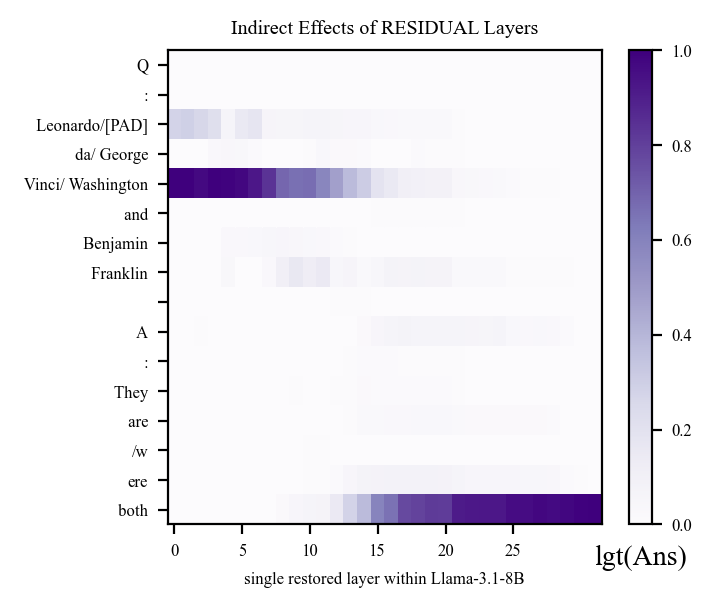

===> trace_start_idx=204
2025-03-26 18:13:23 src.trace DEBUG    base_score=17.171875 | base_indv_scores={46033: 17.171875}
2025-03-26 18:13:23 src.trace DEBUG    low_score=11.9453125 | low_indv_scores={46033: 11.9453125}
2025-03-26 18:13:23 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 512/512 [00:33<00:00, 15.44it/s]

2025-03-26 18:13:57 src.trace INFO     base_score=17.171875 | low_score=11.9453125


2025-03-26 18:13:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff6785629d0>
2025-03-26 18:13:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:13:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:13:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:13:57 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


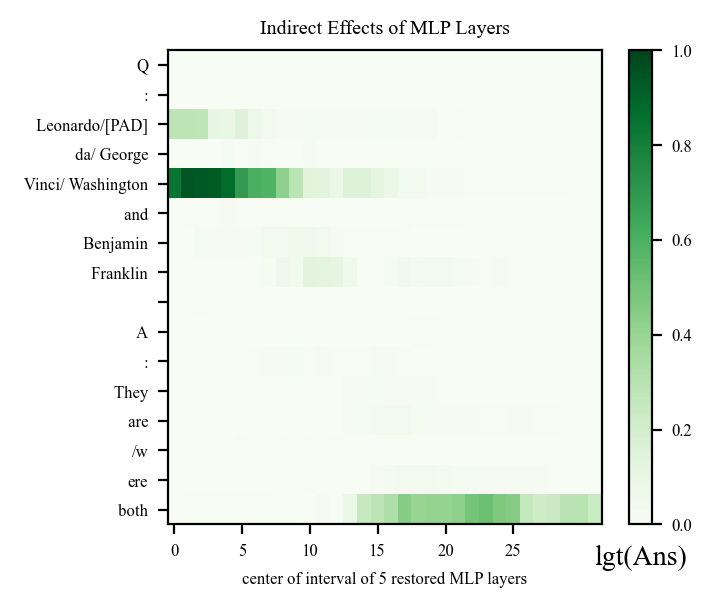

===> trace_start_idx=204
2025-03-26 18:13:57 src.trace DEBUG    base_score=17.171875 | base_indv_scores={46033: 17.171875}
2025-03-26 18:13:57 src.trace DEBUG    low_score=11.9453125 | low_indv_scores={46033: 11.9453125}
2025-03-26 18:13:57 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 512/512 [00:33<00:00, 15.23it/s]

2025-03-26 18:14:31 src.trace INFO     base_score=17.171875 | low_score=11.9453125


2025-03-26 18:14:31 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ff657819c50>
2025-03-26 18:14:31 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:14:31 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:14:31 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-26 18:14:31 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


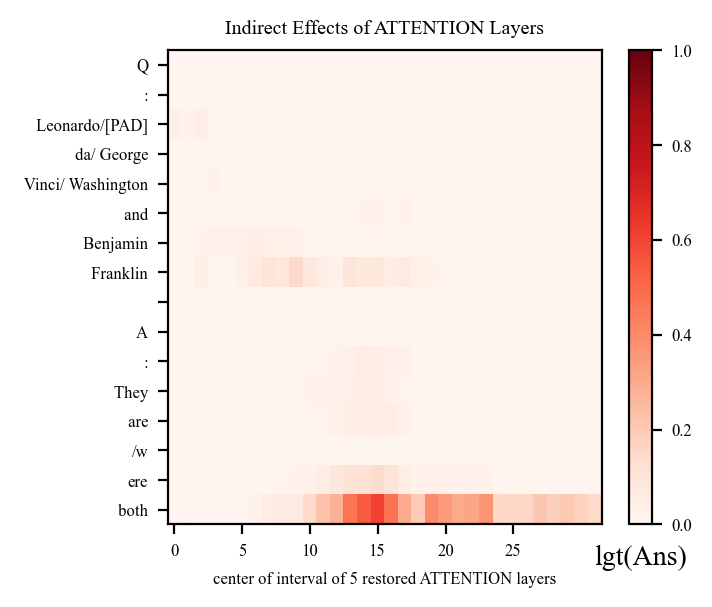

In [64]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap
from src.functional import predict_next_token

prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

for kind in ["residual", "mlp", "attention"]:
# for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        patched_input=TokenizerOutput(data=patched_prompt.tokenized),
        trace_start_marker="#",
        metric="logit",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=keywords
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None
    )

In [18]:
# from src.trace import trace_important_states
# from src.utils.typing import TokenizerOutput
# from src.plotting import plot_trace_heatmap
# from src.functional import predict_next_token

# prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

# for kind in ["residual", "mlp", "attention"]:
# # for kind in ["residual"]:
#     trace_results = trace_important_states(
#         mt=mt,
#         prompt_template=prompt_template,
#         clean_subj=clean_entity,
#         patched_subj=patch_entity,
#         clean_input=TokenizerOutput(data=clean_prompt.tokenized),
#         patched_input=TokenizerOutput(data=patched_prompt.tokenized),
#         trace_start_marker="#",
#         metric="logit",
#         # normalize=False,
#         kind=kind,
#         window_size=1 if kind == "residual" else 5,
#         # ans_tokens=keywords
#     )

#     plot_trace_heatmap(
#         result=trace_results,
#         model_name=model_key.split("/")[-1],
#         scale_range=(0, 1) if trace_results.normalized == True else None
#     )

In [19]:
# trace_results.answer

In [20]:
# from src.functional import detensorize
# import numpy as np

# trace_results_dten = detensorize(trace_results)

# np.savez_compressed(
#     "test.npz",
#     **trace_results_dten.__dict__,
#     allow_pickle=True
# )

In [21]:
# npz_file = np.load("test.npz", allow_pickle=True)
# npz_file.files

In [22]:
# from src.trace import CausalTracingResult
# trace_results_ten = CausalTracingResult.from_npz(file=npz_file)

# plot_trace_heatmap(
#     result=trace_results,
#     model_name=model_key.split("/")[-1],
#     scale_range=(0, 1) if trace_results.normalized == True else None
# )

In [23]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-03-26 17:12:47 __main__ INFO     len(coincidences['examples'])=14


In [24]:
coincidences['examples'][1]

{'entity_pair': ['Hugh Jackman', 'Ryan Reynolds'],
 'connection': 'X-men characters.',
 'alt_first': {'entity': 'Celine Dion', 'connection': 'Canadian.'}}

In [32]:
from src.functional import detensorize
import numpy as np

save_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "causal_tracing_keywords")
os.makedirs(save_dir, exist_ok=True)

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

    common_entity = entities[1]
    patch_entity = entities[0]
    clean_entity = c["alt_first"]["entity"]

    clean_prompt = prepare_probing_input(
        mt=mt,
        entities=(clean_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )
    clean_answer = get_lm_generated_answer(
        mt=mt, prompt=clean_prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
    )
    logger.info(f"({clean_entity}, {common_entity}) => {clean_answer}")

    patched_prompt = prepare_probing_input(
        mt=mt,
        entities=(patch_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )

    patched_answer = get_lm_generated_answer(
        mt=mt, prompt=patched_prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
    )
    logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")

    keywords = get_keywords(text = patched_answer, tokenizer=mt)

    # generations = generate_with_beam_search(
    #     mt = mt,
    #     inputs = TokenizerOutput(data = patched_prompt.tokenized),
    #     no_repeat_ngram_size=3,
    #     processor=trim_generation
    # )
    # print(json.dumps(generations, indent=2))
    # keywords = []
    # for gen in generations:
    #     keywords += get_keywords(text = gen, tokenizer=mt)

    # patched_pred = predict_next_token(mt=mt, inputs = patched_prompt.prompt, k = 5)[0]
    # keywords += [p.token_id for p in patched_pred]
    # keywords = list(set(keywords))
    print(f"keywords={[mt.tokenizer.decode([k]) for k in keywords]}")

    prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

    file_name = f"{patch_entity}__<>__{clean_entity}.npz"
    for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
        try:
        # if True:
            trace_results = trace_important_states(
                mt=mt,
                prompt_template=prompt_template,
                clean_subj=clean_entity,
                patched_subj=patch_entity,
                clean_input=TokenizerOutput(data=clean_prompt.tokenized),
                patched_input=TokenizerOutput(data=patched_prompt.tokenized),
                trace_start_marker="#",
                metric="logit",
                # normalize=False,
                kind=kind,
                window_size=1 if kind == "residual" else 5,
                ans_tokens=keywords
            )
            kind_save_dir = os.path.join(save_dir, kind)
            os.makedirs(kind_save_dir, exist_ok=True)
            print("saving to >> ", kind_save_dir)

            trace_results_dten = detensorize(trace_results)

            np.savez_compressed(
                os.path.join(kind_save_dir, f"{file_name}"),
                **trace_results_dten.__dict__,
                allow_pickle=True
            )
        except Exception as e:
            logger.error(f"Error in {entities=} => {e}")
            logger.warning(f"Skipping {file_name}")
            continue
    
    print("-"*100)
    print("\n")

2025-03-26 17:34:44 __main__ INFO     (1/14)  entities=['Germany', 'Japan']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:34:45 __main__ INFO     (Korea, Japan) => countries in East Asia.
2025-03-26 17:34:47 __main__ INFO     (Germany, Japan) => Axis powers in World War II.
keywords=[' Axis', ' powers', ' World', ' War', ' II']
===> trace_start_idx=203
2025-03-26 17:34:47 src.trace DEBUG    base_score=10.703125 | base_indv_scores={35574: 16.1875, 13736: 11.390625, 4435: 14.2265625, 5111: 6.8828125, 8105: 4.8203125}
2025-03-26 17:34:47 src.trace DEBUG    low_score=8.078125 | low_indv_scores={35574: 12.3828125, 13736: 10.5, 4435: 9.375, 5111: 5.484375, 8105: 2.634765625}
2025-03-26 17:34:47 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 448/448 [00:26<00:00, 16.61it/s]

2025-03-26 17:35:14 src.trace INFO     base_score=10.703125 | low_score=8.078125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:35:15 src.trace DEBUG    base_score=10.703125 | base_indv_scores={35574: 16.1875, 13736: 11.390625, 4435: 14.2265625, 5111: 6.8828125, 8105: 4.8203125}
2025-03-26 17:35:15 src.trace DEBUG    low_score=8.078125 | low_indv_scores={35574: 12.3828125, 13736: 10.5, 4435: 9.375, 5111: 5.484375, 8105: 2.634765625}
2025-03-26 17:35:15 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 448/448 [00:27<00:00, 16.12it/s]

2025-03-26 17:35:43 src.trace INFO     base_score=10.703125 | low_score=8.078125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:35:44 src.trace DEBUG    base_score=10.703125 | base_indv_scores={35574: 16.1875, 13736: 11.390625, 4435: 14.2265625, 5111: 6.8828125, 8105: 4.8203125}
2025-03-26 17:35:44 src.trace DEBUG    low_score=8.078125 | low_indv_scores={35574: 12.3828125, 13736: 10.5, 4435: 9.375, 5111: 5.484375, 8105: 2.634765625}
2025-03-26 17:35:44 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 448/448 [00:28<00:00, 15.93it/s]

2025-03-26 17:36:13 src.trace INFO     base_score=10.703125 | low_score=8.078125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:36:14 __main__ INFO     (2/14)  entities=['Hugh Jackman', 'Ryan Reynolds']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:36:15 __main__ INFO     (Celine Dion, Ryan Reynolds) => Canadian.
2025-03-26 17:36:17 __main__ INFO     (Hugh Jackman, Ryan Reynolds) => X-Men characters.
keywords=[' X', ' characters']
===> trace_start_idx=203
2025-03-26 17:36:17 src.trace DEBUG    base_score=13.546875 | base_indv_scores={1630: 15.5859375, 5885: 11.5}
2025-03-26 17:36:17 src.trace DEBUG    low_score=7.91796875 | low_indv_scores={1630: 8.234375, 5885: 7.6015625}
2025-03-26 17:36:17 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 544/544 [00:35<00:00, 15.50it/s]

2025-03-26 17:36:52 src.trace INFO     base_score=13.546875 | low_score=7.91796875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:36:53 src.trace DEBUG    base_score=13.546875 | base_indv_scores={1630: 15.5859375, 5885: 11.5}
2025-03-26 17:36:53 src.trace DEBUG    low_score=7.91796875 | low_indv_scores={1630: 8.234375, 5885: 7.6015625}
2025-03-26 17:36:53 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 544/544 [00:39<00:00, 13.71it/s]

2025-03-26 17:37:32 src.trace INFO     base_score=13.546875 | low_score=7.91796875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:37:33 src.trace DEBUG    base_score=13.546875 | base_indv_scores={1630: 15.5859375, 5885: 11.5}
2025-03-26 17:37:33 src.trace DEBUG    low_score=7.91796875 | low_indv_scores={1630: 8.234375, 5885: 7.6015625}
2025-03-26 17:37:33 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 544/544 [00:37<00:00, 14.64it/s]

2025-03-26 17:38:10 src.trace INFO     base_score=13.546875 | low_score=7.91796875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:38:11 __main__ INFO     (3/14)  entities=['Bhutan', 'Nepal']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:38:12 __main__ INFO     (India, Nepal) => part of the British Empire.
2025-03-26 17:38:14 __main__ INFO     (Bhutan, Nepal) => kingdoms in the Himalayas.
keywords=[' kingdoms', ' Himal']
===> trace_start_idx=204
2025-03-26 17:38:14 src.trace DEBUG    base_score=16.640625 | base_indv_scores={96506: 16.84375, 76438: 16.4375}
2025-03-26 17:38:14 src.trace DEBUG    low_score=13.453125 | low_indv_scores={96506: 14.7265625, 76438: 12.1796875}
2025-03-26 17:38:14 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 448/448 [00:28<00:00, 15.88it/s]

2025-03-26 17:38:42 src.trace INFO     base_score=16.640625 | low_score=13.453125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=204
2025-03-26 17:38:43 src.trace DEBUG    base_score=16.640625 | base_indv_scores={96506: 16.84375, 76438: 16.4375}
2025-03-26 17:38:43 src.trace DEBUG    low_score=13.453125 | low_indv_scores={96506: 14.7265625, 76438: 12.1796875}
2025-03-26 17:38:43 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 448/448 [00:29<00:00, 15.43it/s]

2025-03-26 17:39:12 src.trace INFO     base_score=16.640625 | low_score=13.453125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=204
2025-03-26 17:39:13 src.trace DEBUG    base_score=16.640625 | base_indv_scores={96506: 16.84375, 76438: 16.4375}
2025-03-26 17:39:13 src.trace DEBUG    low_score=13.453125 | low_indv_scores={96506: 14.7265625, 76438: 12.1796875}
2025-03-26 17:39:13 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 448/448 [00:29<00:00, 15.32it/s]

2025-03-26 17:39:42 src.trace INFO     base_score=16.640625 | low_score=13.453125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:39:43 __main__ INFO     (4/14)  entities=['Mount Athos', 'Vatican City']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:39:45 __main__ INFO     (Italy, Vatican City) => part of the Roman Empire.
2025-03-26 17:39:46 __main__ INFO     (Mount Athos, Vatican City) => monasteries.
keywords=[' mon']
2025-03-26 17:39:46 __main__ ERROR    Error in entities=['Mount Athos', 'Vatican City'] => Replacement index 1 out of range for positional args tuple
2025-03-26 17:39:46 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-03-26 17:39:46 __main__ ERROR    Error in entities=['Mount Athos', 'Vatican City'] => Replacement index 1 out of range for positional args tuple
2025-03-26 17:39:46 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-03-26 17:39:46 __main__ ERROR    Error in entities=['Mount Athos', 'Vatican City'] => Replacement index 1 out of range for positional args tuple
2025-03-26 17:39:46 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
----------------------------------------------------------------------------------------------------


2025-03-26 17:39:46 __main__ INFO   

100%|██████████| 608/608 [00:38<00:00, 15.89it/s]

2025-03-26 17:40:27 src.trace INFO     base_score=16.90625 | low_score=16.625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:40:28 src.trace DEBUG    base_score=16.90625 | base_indv_scores={14154: 17.734375, 36136: 16.078125}
2025-03-26 17:40:28 src.trace DEBUG    low_score=16.625 | low_indv_scores={14154: 16.53125, 36136: 16.71875}
2025-03-26 17:40:28 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 608/608 [00:38<00:00, 15.86it/s]

2025-03-26 17:41:06 src.trace INFO     base_score=16.90625 | low_score=16.625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:41:07 src.trace DEBUG    base_score=16.90625 | base_indv_scores={14154: 17.734375, 36136: 16.078125}
2025-03-26 17:41:07 src.trace DEBUG    low_score=16.625 | low_indv_scores={14154: 16.53125, 36136: 16.71875}
2025-03-26 17:41:07 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 608/608 [00:38<00:00, 15.94it/s]

2025-03-26 17:41:45 src.trace INFO     base_score=16.90625 | low_score=16.625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:41:46 __main__ INFO     (6/14)  entities=['Leonardo da Vinci', 'Benjamin Franklin']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:41:47 __main__ INFO     (Benjamin Franklin, Benjamin Franklin) => American Founding Fathers.
2025-03-26 17:41:49 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.
keywords=[' polym']
2025-03-26 17:41:49 __main__ ERROR    Error in entities=['Leonardo da Vinci', 'Benjamin Franklin'] => Replacement index 1 out of range for positional args tuple
2025-03-26 17:41:49 __main__ WARNING  Skipping Leonardo da Vinci__<>__Benjamin Franklin.npz
2025-03-26 17:41:49 __main__ ERROR    Error in entities=['Leonardo da Vinci', 'Benjamin Franklin'] => Replacement index 1 out of range for positional args tuple
2025-03-26 17:41:49 __main__ WARNING  Skipping Leonardo da Vinci__<>__Benjamin Franklin.npz
2025-03-26 17:41:49 __main__ ERROR    Error in entities=['Leonardo da Vinci', 'Benjamin Franklin'] => Replacement index 1 out of range for positional args tuple
2025-03-26 17:41:49 __main__ WARNING  Skipping Leonardo da Vinci__<>__Benjamin Franklin.npz
-----------------------

100%|██████████| 512/512 [00:32<00:00, 15.61it/s]

2025-03-26 17:42:25 src.trace INFO     base_score=17.109375 | low_score=8.21875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=206
2025-03-26 17:42:25 src.trace DEBUG    base_score=17.109375 | base_indv_scores={18507: 17.109375}
2025-03-26 17:42:25 src.trace DEBUG    low_score=8.21875 | low_indv_scores={18507: 8.21875}
2025-03-26 17:42:25 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 512/512 [00:31<00:00, 16.13it/s]

2025-03-26 17:42:57 src.trace INFO     base_score=17.109375 | low_score=8.21875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=206
2025-03-26 17:42:58 src.trace DEBUG    base_score=17.109375 | base_indv_scores={18507: 17.109375}
2025-03-26 17:42:58 src.trace DEBUG    low_score=8.21875 | low_indv_scores={18507: 8.21875}
2025-03-26 17:42:58 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 512/512 [00:32<00:00, 15.57it/s]

2025-03-26 17:43:30 src.trace INFO     base_score=17.109375 | low_score=8.21875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:43:31 __main__ INFO     (8/14)  entities=['Julius Caesar', 'Nepoleon Bonaparte']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:43:32 __main__ INFO     (Victor Hugo, Nepoleon Bonaparte) => French.
2025-03-26 17:43:34 __main__ INFO     (Julius Caesar, Nepoleon Bonaparte) => military leaders.
keywords=[' military', ' leaders']
===> trace_start_idx=203
2025-03-26 17:43:34 src.trace DEBUG    base_score=16.921875 | base_indv_scores={6411: 17.53125, 6164: 16.3125}
2025-03-26 17:43:34 src.trace DEBUG    low_score=12.25 | low_indv_scores={6411: 11.921875, 6164: 12.578125}
2025-03-26 17:43:34 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 608/608 [00:38<00:00, 15.87it/s]

2025-03-26 17:44:12 src.trace INFO     base_score=16.921875 | low_score=12.25


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:44:13 src.trace DEBUG    base_score=16.921875 | base_indv_scores={6411: 17.53125, 6164: 16.3125}
2025-03-26 17:44:13 src.trace DEBUG    low_score=12.25 | low_indv_scores={6411: 11.921875, 6164: 12.578125}
2025-03-26 17:44:13 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 608/608 [00:38<00:00, 15.96it/s]

2025-03-26 17:44:51 src.trace INFO     base_score=16.921875 | low_score=12.25


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:44:52 src.trace DEBUG    base_score=16.921875 | base_indv_scores={6411: 17.53125, 6164: 16.3125}
2025-03-26 17:44:52 src.trace DEBUG    low_score=12.25 | low_indv_scores={6411: 11.921875, 6164: 12.578125}
2025-03-26 17:44:52 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 608/608 [00:38<00:00, 15.72it/s]

2025-03-26 17:45:31 src.trace INFO     base_score=16.921875 | low_score=12.25


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:45:31 __main__ INFO     (9/14)  entities=['Christopher Columbus', 'Vasco da Gama']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:45:33 __main__ INFO     (Christiano Ronaldo, Vasco da Gama) => football players.
2025-03-26 17:45:34 __main__ INFO     (Christopher Columbus, Vasco da Gama) => explorers.
keywords=[' explor']
===> trace_start_idx=203
2025-03-26 17:45:34 src.trace DEBUG    base_score=18.625 | base_indv_scores={48539: 18.625}
2025-03-26 17:45:34 src.trace DEBUG    low_score=6.12109375 | low_indv_scores={48539: 6.12109375}
2025-03-26 17:45:34 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 640/640 [00:39<00:00, 16.02it/s]

2025-03-26 17:46:14 src.trace INFO     base_score=18.625 | low_score=6.12109375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:46:15 src.trace DEBUG    base_score=18.625 | base_indv_scores={48539: 18.625}
2025-03-26 17:46:15 src.trace DEBUG    low_score=6.12109375 | low_indv_scores={48539: 6.12109375}
2025-03-26 17:46:15 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 640/640 [00:40<00:00, 15.93it/s]

2025-03-26 17:46:55 src.trace INFO     base_score=18.625 | low_score=6.12109375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:46:56 src.trace DEBUG    base_score=18.625 | base_indv_scores={48539: 18.625}
2025-03-26 17:46:56 src.trace DEBUG    low_score=6.12109375 | low_indv_scores={48539: 6.12109375}
2025-03-26 17:46:56 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 640/640 [00:40<00:00, 15.96it/s]

2025-03-26 17:47:36 src.trace INFO     base_score=18.625 | low_score=6.12109375


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:47:36 __main__ INFO     (10/14)  entities=['Whale', 'Elephant']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:47:38 __main__ INFO     (Horse, Elephant) => domesticated animals.
2025-03-26 17:47:39 __main__ INFO     (Whale, Elephant) => mammals.
keywords=[' mammals']
===> trace_start_idx=203
2025-03-26 17:47:39 src.trace DEBUG    base_score=16.9375 | base_indv_scores={56669: 16.9375}
2025-03-26 17:47:39 src.trace DEBUG    low_score=15.640625 | low_indv_scores={56669: 15.640625}
2025-03-26 17:47:39 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 448/448 [00:26<00:00, 16.66it/s]

2025-03-26 17:48:06 src.trace INFO     base_score=16.9375 | low_score=15.640625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:48:07 src.trace DEBUG    base_score=16.9375 | base_indv_scores={56669: 16.9375}
2025-03-26 17:48:07 src.trace DEBUG    low_score=15.640625 | low_indv_scores={56669: 15.640625}
2025-03-26 17:48:07 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 448/448 [00:27<00:00, 16.28it/s]

2025-03-26 17:48:34 src.trace INFO     base_score=16.9375 | low_score=15.640625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:48:35 src.trace DEBUG    base_score=16.9375 | base_indv_scores={56669: 16.9375}
2025-03-26 17:48:35 src.trace DEBUG    low_score=15.640625 | low_indv_scores={56669: 15.640625}
2025-03-26 17:48:35 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 448/448 [00:27<00:00, 16.39it/s]

2025-03-26 17:49:02 src.trace INFO     base_score=16.9375 | low_score=15.640625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:49:03 __main__ INFO     (11/14)  entities=['Ostrich', 'Emu']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:49:04 __main__ INFO     (Kangaroo, Emu) => native to Australia.
2025-03-26 17:49:06 __main__ INFO     (Ostrich, Emu) => flightless birds.
keywords=[' flight', ' birds']
===> trace_start_idx=204
2025-03-26 17:49:07 src.trace DEBUG    base_score=15.0 | base_indv_scores={11213: 16.265625, 20229: 13.734375}
2025-03-26 17:49:07 src.trace DEBUG    low_score=14.953125 | low_indv_scores={11213: 15.6484375, 20229: 14.2578125}
2025-03-26 17:49:07 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 512/512 [00:31<00:00, 16.13it/s]

2025-03-26 17:49:39 src.trace INFO     base_score=15.0 | low_score=14.953125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=204
2025-03-26 17:49:40 src.trace DEBUG    base_score=15.0 | base_indv_scores={11213: 16.265625, 20229: 13.734375}
2025-03-26 17:49:40 src.trace DEBUG    low_score=14.953125 | low_indv_scores={11213: 15.6484375, 20229: 14.2578125}
2025-03-26 17:49:40 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 512/512 [00:36<00:00, 14.12it/s]

2025-03-26 17:50:16 src.trace INFO     base_score=15.0 | low_score=14.953125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=204
2025-03-26 17:50:17 src.trace DEBUG    base_score=15.0 | base_indv_scores={11213: 16.265625, 20229: 13.734375}
2025-03-26 17:50:17 src.trace DEBUG    low_score=14.953125 | low_indv_scores={11213: 15.6484375, 20229: 14.2578125}
2025-03-26 17:50:17 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 512/512 [00:32<00:00, 15.81it/s]

2025-03-26 17:50:49 src.trace INFO     base_score=15.0 | low_score=14.953125


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:50:50 __main__ INFO     (12/14)  entities=['jellyfish', 'lobster']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:50:51 __main__ INFO     (salmon, lobster) => popular seafood dishes.
2025-03-26 17:50:53 __main__ INFO     (jellyfish, lobster) => invertebrates.
keywords=[' in']
===> trace_start_idx=204
2025-03-26 17:50:53 src.trace DEBUG    base_score=15.6484375 | base_indv_scores={304: 15.6484375}
2025-03-26 17:50:53 src.trace DEBUG    low_score=12.765625 | low_indv_scores={304: 12.765625}
2025-03-26 17:50:53 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 448/448 [00:26<00:00, 16.72it/s]

2025-03-26 17:51:20 src.trace INFO     base_score=15.6484375 | low_score=12.765625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=204
2025-03-26 17:51:20 src.trace DEBUG    base_score=15.6484375 | base_indv_scores={304: 15.6484375}
2025-03-26 17:51:20 src.trace DEBUG    low_score=12.765625 | low_indv_scores={304: 12.765625}
2025-03-26 17:51:20 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 448/448 [00:26<00:00, 16.65it/s]

2025-03-26 17:51:47 src.trace INFO     base_score=15.6484375 | low_score=12.765625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=204
2025-03-26 17:51:48 src.trace DEBUG    base_score=15.6484375 | base_indv_scores={304: 15.6484375}
2025-03-26 17:51:48 src.trace DEBUG    low_score=12.765625 | low_indv_scores={304: 12.765625}
2025-03-26 17:51:48 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 448/448 [00:28<00:00, 15.82it/s]

2025-03-26 17:52:16 src.trace INFO     base_score=15.6484375 | low_score=12.765625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:52:17 __main__ INFO     (13/14)  entities=['crocodile', 'shark']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:52:18 __main__ INFO     (salmon, shark) => fish.
2025-03-26 17:52:20 __main__ INFO     (crocodile, shark) => apex predators.
keywords=[' apex', ' predators']
===> trace_start_idx=204
2025-03-26 17:52:20 src.trace DEBUG    base_score=15.0625 | base_indv_scores={72627: 15.6875, 56217: 14.4296875}
2025-03-26 17:52:20 src.trace DEBUG    low_score=12.546875 | low_indv_scores={72627: 12.125, 56217: 12.9609375}
2025-03-26 17:52:20 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 448/448 [00:31<00:00, 14.39it/s]

2025-03-26 17:52:51 src.trace INFO     base_score=15.0625 | low_score=12.546875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=204
2025-03-26 17:52:52 src.trace DEBUG    base_score=15.0625 | base_indv_scores={72627: 15.6875, 56217: 14.4296875}
2025-03-26 17:52:52 src.trace DEBUG    low_score=12.546875 | low_indv_scores={72627: 12.125, 56217: 12.9609375}
2025-03-26 17:52:52 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 448/448 [00:27<00:00, 16.54it/s]

2025-03-26 17:53:19 src.trace INFO     base_score=15.0625 | low_score=12.546875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=204
2025-03-26 17:53:20 src.trace DEBUG    base_score=15.0625 | base_indv_scores={72627: 15.6875, 56217: 14.4296875}
2025-03-26 17:53:20 src.trace DEBUG    low_score=12.546875 | low_indv_scores={72627: 12.125, 56217: 12.9609375}
2025-03-26 17:53:20 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 448/448 [00:27<00:00, 16.46it/s]

2025-03-26 17:53:47 src.trace INFO     base_score=15.0625 | low_score=12.546875


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-03-26 17:53:47 __main__ INFO     (14/14)  entities=['spider', 'crab']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-03-26 17:53:49 __main__ INFO     (lobster, crab) => crustaceans.
2025-03-26 17:53:50 __main__ INFO     (spider, crab) => arthropods.
keywords=[' ar']
===> trace_start_idx=203
2025-03-26 17:53:50 src.trace DEBUG    base_score=15.40625 | base_indv_scores={802: 15.40625}
2025-03-26 17:53:50 src.trace DEBUG    low_score=13.640625 | low_indv_scores={802: 13.640625}
2025-03-26 17:53:50 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 448/448 [00:26<00:00, 16.74it/s]

2025-03-26 17:54:17 src.trace INFO     base_score=15.40625 | low_score=13.640625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-03-26 17:54:18 src.trace DEBUG    base_score=15.40625 | base_indv_scores={802: 15.40625}
2025-03-26 17:54:18 src.trace DEBUG    low_score=13.640625 | low_indv_scores={802: 13.640625}
2025-03-26 17:54:18 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 448/448 [00:26<00:00, 16.70it/s]

2025-03-26 17:54:45 src.trace INFO     base_score=15.40625 | low_score=13.640625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-03-26 17:54:45 src.trace DEBUG    base_score=15.40625 | base_indv_scores={802: 15.40625}
2025-03-26 17:54:45 src.trace DEBUG    low_score=13.640625 | low_indv_scores={802: 13.640625}
2025-03-26 17:54:45 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 448/448 [00:27<00:00, 16.03it/s]

2025-03-26 17:55:13 src.trace INFO     base_score=15.40625 | low_score=13.640625


saving to >>  /home/local_arnab/Codes/Projects/retrieval/results/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------




In [14]:
from src.trace import CausalTracingResult
import numpy as np

load_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "causal_tracing_keywords", "residual")

indirect_effects_collection = []
for file_name in os.listdir(load_dir):
    npz_file = np.load(os.path.join(load_dir, file_name), allow_pickle=True)
    indirect_effects_collection.append(CausalTracingResult.from_npz(npz_file))

In [15]:
from src.tokens import prepare_input, find_token_range
from src.trace import CausalTracingResult


def find_common_entity_range(mt, toks, common_entity):
    text = "".join(toks)
    inputs = prepare_input(
        prompts=text,
        tokenizer=mt,
        add_special_tokens=False,
        return_offsets_mapping=True,
    )
    rng = find_token_range(
        string=text,
        substring=common_entity,
        tokenizer=mt,
        offset_mapping=inputs["offset_mapping"][0],
        occurence=-1,
    )
    return rng


def get_token_ranges(
    mt: ModelandTokenizer,
    trace_res: CausalTracingResult,
    common_entity: str,
):
    common_entity_range_patch = find_common_entity_range(mt, trace_res.patch_input_toks, common_entity)

    # common_entity_range_clean = find_common_entity_range(mt, trace_res.corrupt_input_toks, common_entity)
    # print(common_entity_range_patch, common_entity_range_clean)

    # print(trace_res.patch_input_toks[slice(*common_entity_range_patch)])
    # print(trace_res.patch_input_toks[200:])

    # print(trace_res.corrupt_input_toks[slice(*common_entity_range_patch)])
    # print(trace_res.corrupt_input_toks[200:])

    # assert common_entity_range_patch == common_entity_range_clean
    assert trace_res.patch_input_toks[slice(*common_entity_range_patch)] == trace_res.corrupt_input_toks[slice(*common_entity_range_patch)]

    between_entities = (trace_res.subj_range[1], common_entity_range_patch[0])

    query_indices = (common_entity_range_patch[1], len(trace_res.patch_input_toks) - 2)

    subj_len = trace_res.subj_range[1] - trace_res.subj_range[0]
    common_len = common_entity_range_patch[1] - common_entity_range_patch[0]

    return dict(
        previous = (trace_res.trace_start_idx, trace_res.subj_range[0]),
        subj_upto_2nd_last = (trace_res.subj_range[0], trace_res.subj_range[1] - 2) if subj_len > 2 else None,
        subj_2nd_last = trace_res.subj_range[1] - 2 if subj_len >= 2 else None,
        subj_last = trace_res.subj_range[1] - 1,
        between_entities=between_entities,
        common_upto_2nd_last = (common_entity_range_patch[0], common_entity_range_patch[1] - 2) if common_len > 2 else None,
        common_2nd_last = common_entity_range_patch[1] - 2 if common_len >= 2 else None,
        common_last = common_entity_range_patch[1] - 1,
        query_indices=query_indices,
        second_last=-2,
        last=-1,
    ) 


def get_categorized_indirect_effects(trace_res: CausalTracingResult, token_ranges: dict[str, int | tuple[int, int]]):
    indirect_effects = {}
    for category in token_ranges:
        if token_ranges[category] is None:
            indirect_effects[category] = None
            continue
        if isinstance(token_ranges[category], int) == False:
            rng = token_ranges[category]
            rng = (rng[0] - trace_res.trace_start_idx, rng[1] - trace_res.trace_start_idx)
            indirect_effects[category] = trace_res.indirect_effects[rng[0] : rng[1]].mean(dim=0)
        else:
            idx = token_ranges[category]
            idx = idx - trace_res.trace_start_idx if idx > 0 else idx
            indirect_effects[category] = trace_res.indirect_effects[idx]
    
    return indirect_effects
        
sample_idx = 10
trace_res = indirect_effects_collection[10] 
token_ranges = get_token_ranges(
    mt, trace_res, common_entity=coincidences["examples"][sample_idx]["entity_pair"][1]
)
categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)

In [16]:
from typing import Literal
from src.utils.typing import PredictedToken

def average_indirect_effects(
    categorized_effects: list[dict], 
    kind: Literal["residual", "mlp", "attention"] = "residual",
    window: int = 1,
    metric: Literal["logit", "prob"] = "logit"
):
    aie = {k: torch.zeros(mt.n_layer) for k, v in categorized_effects[0].items()}
    for category in aie:
        category_count = 0
        for effects in categorized_effects:
            if effects[category] is not None:
                aie[category] += effects[category]
                category_count += 1
        if category_count > 0:
            aie[category] /= category_count

    return CausalTracingResult(
        patch_input_toks=list(aie.keys()),
        corrupt_input_toks=list(aie.keys()),
        indirect_effects=torch.stack(list(aie.values())),
        trace_start_idx=0,
        answer = [PredictedToken(token="Ans", prob=1.0, logit=10.0)],
        low_score=0.0,
        subj_range=(1, 4),
        normalized=True,
        kind=kind,
        window=window,
        metric=metric
    )

aie = average_indirect_effects(categorized_effects=[categorized_effects])

2025-03-28 11:10:50 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2025-03-28 11:10:50 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2025-03-28 11:10:50 matplotlib DEBUG    interactive is False
2025-03-28 11:10:50 matplotlib DEBUG    platform is linux
2025-03-28 11:10:50 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2025-03-28 11:10:50 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2025-03-28 11:10:50 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-28 11:10:50 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-28 11:10:50 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-03-28 11:10:

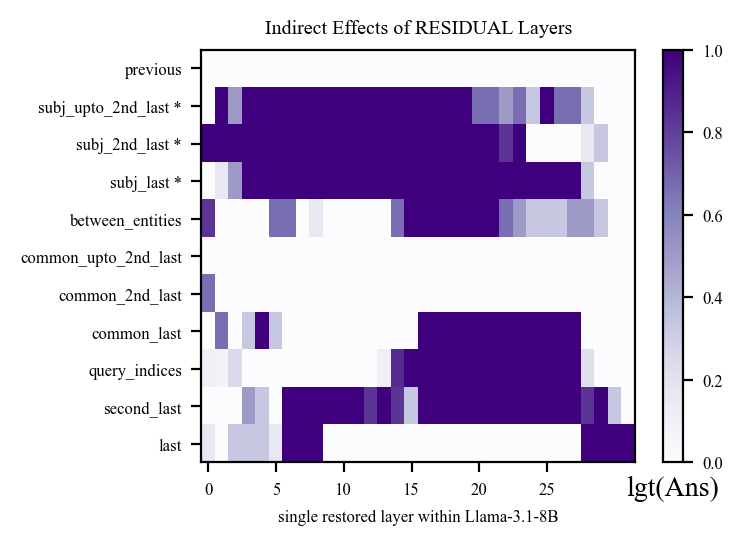

In [18]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(
    result=aie,
    model_name=model_key.split("/")[-1],
    scale_range=(0, 1) if aie.normalized == True else None
)

2025-03-26 18:03:41 __main__ INFO     (1/14)  entities=['Germany', 'Japan']
2025-03-26 18:03:41 __main__ INFO     (2/14)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-03-26 18:03:41 __main__ INFO     (3/14)  entities=['Bhutan', 'Nepal']
2025-03-26 18:03:41 __main__ INFO     (4/14)  entities=['Mount Athos', 'Vatican City']
2025-03-26 18:03:41 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-03-26 18:03:41 __main__ INFO     (5/14)  entities=['Dead Sea Scrolls', 'Rosetta Stone']
2025-03-26 18:03:41 __main__ INFO     (6/14)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-03-26 18:03:41 __main__ WARNING  Skipping Leonardo da Vinci__<>__Benjamin Franklin.npz
2025-03-26 18:03:41 __main__ INFO     (7/14)  entities=['Toph Beifong', 'Daredevil']
2025-03-26 18:03:41 __main__ INFO     (8/14)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-03-26 18:03:41 __main__ INFO     (9/14)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-03-26 18:03:41 __main__ INFO     (

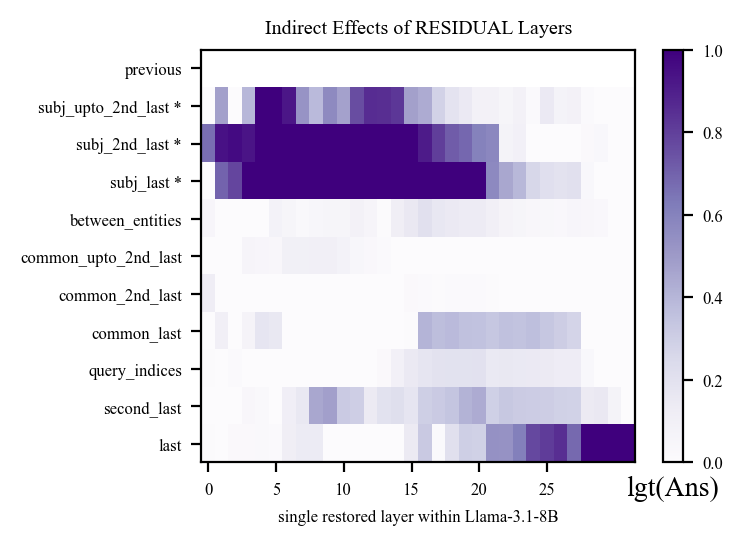

2025-03-26 18:03:41 __main__ INFO     (1/14)  entities=['Germany', 'Japan']
2025-03-26 18:03:41 __main__ INFO     (2/14)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-03-26 18:03:41 __main__ INFO     (3/14)  entities=['Bhutan', 'Nepal']
2025-03-26 18:03:41 __main__ INFO     (4/14)  entities=['Mount Athos', 'Vatican City']
2025-03-26 18:03:41 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-03-26 18:03:41 __main__ INFO     (5/14)  entities=['Dead Sea Scrolls', 'Rosetta Stone']
2025-03-26 18:03:41 __main__ INFO     (6/14)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-03-26 18:03:41 __main__ WARNING  Skipping Leonardo da Vinci__<>__Benjamin Franklin.npz
2025-03-26 18:03:41 __main__ INFO     (7/14)  entities=['Toph Beifong', 'Daredevil']
2025-03-26 18:03:41 __main__ INFO     (8/14)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-03-26 18:03:41 __main__ INFO     (9/14)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-03-26 18:03:41 __main__ INFO     (

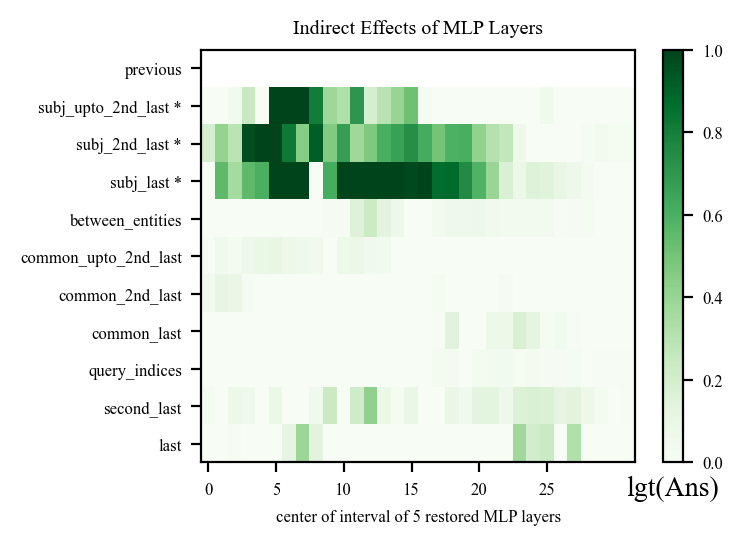

2025-03-26 18:03:42 __main__ INFO     (1/14)  entities=['Germany', 'Japan']
2025-03-26 18:03:42 __main__ INFO     (2/14)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-03-26 18:03:42 __main__ INFO     (3/14)  entities=['Bhutan', 'Nepal']
2025-03-26 18:03:42 __main__ INFO     (4/14)  entities=['Mount Athos', 'Vatican City']
2025-03-26 18:03:42 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-03-26 18:03:42 __main__ INFO     (5/14)  entities=['Dead Sea Scrolls', 'Rosetta Stone']
2025-03-26 18:03:42 __main__ INFO     (6/14)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-03-26 18:03:42 __main__ WARNING  Skipping Leonardo da Vinci__<>__Benjamin Franklin.npz
2025-03-26 18:03:42 __main__ INFO     (7/14)  entities=['Toph Beifong', 'Daredevil']
2025-03-26 18:03:42 __main__ INFO     (8/14)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-03-26 18:03:42 __main__ INFO     (9/14)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-03-26 18:03:42 __main__ INFO     (

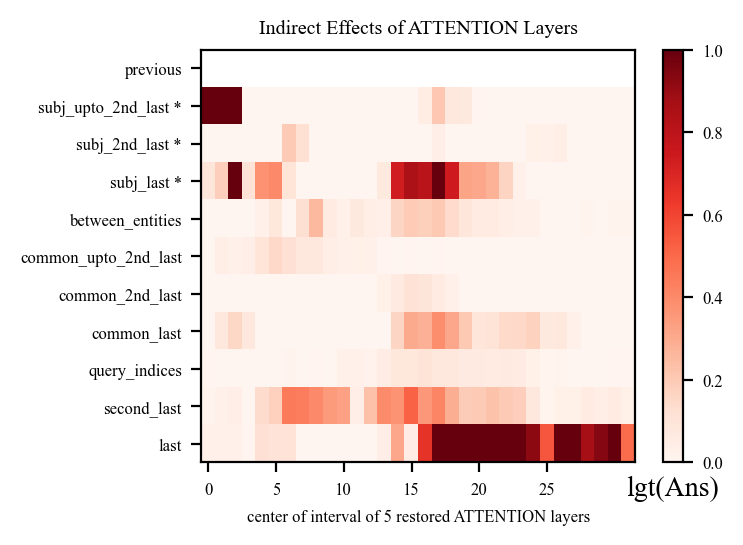

In [44]:
for kind in ["residual", "mlp", "attention"]:
    look_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "causal_tracing_keywords", kind)

    categorized_effects = []
    window, metric = None, None
    for idx, c in enumerate(coincidences["examples"]):
        entities = c["entity_pair"]
        logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

        common_entity = entities[1]
        patch_entity = entities[0]
        clean_entity = c["alt_first"]["entity"]

        file_name = f"{patch_entity}__<>__{clean_entity}.npz"
        if file_name not in os.listdir(look_dir):
            logger.warning(f"Skipping {file_name}")
            continue

        trace_res = CausalTracingResult.from_npz(os.path.join(look_dir, file_name))
        window = trace_res.window
        metric = trace_res.metric
        token_ranges = get_token_ranges(
            mt, trace_res, common_entity=common_entity
        )
        categorized_effects.append(
            get_categorized_indirect_effects(trace_res, token_ranges)
        )

    aie = average_indirect_effects(
        categorized_effects=categorized_effects,
        kind=kind,
        window=window,
        metric=metric,
    )

    plot_trace_heatmap(
        result=aie,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if aie.normalized == True else None
    )

In [39]:
trace_res = indirect_effects_collection[5]
trace_res.__dict__.keys()

dict_keys(['patch_input_toks', 'corrupt_input_toks', 'trace_start_idx', 'answer', 'low_score', 'indirect_effects', 'subj_range', 'normalized', 'kind', 'window', 'metric'])

In [40]:
"".join(trace_res.patch_input_toks[trace_res.subj_range[1] + 1: -8]).strip()

'Rosetta Stone'

[PredictedToken(token=' kingdoms', prob=None, logit=16.84375, token_id=96506), PredictedToken(token=' Himal', prob=None, logit=16.4375, token_id=76438)]
2025-03-28 11:34:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0aceec50>
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


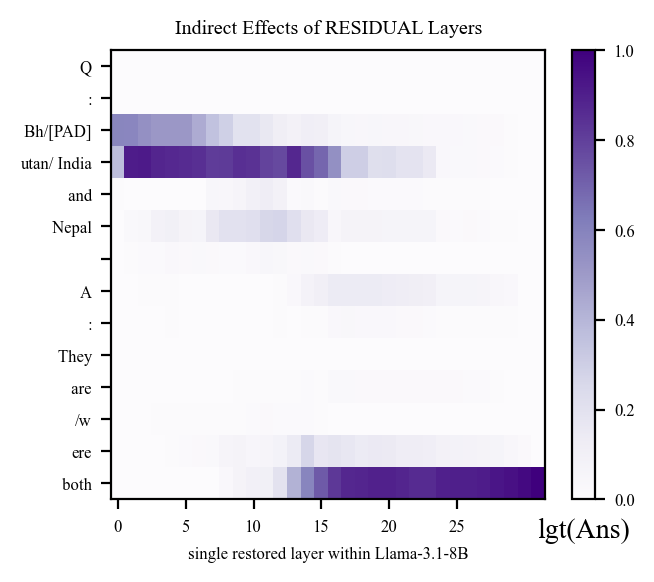

[PredictedToken(token=' military', prob=None, logit=17.53125, token_id=6411), PredictedToken(token=' leaders', prob=None, logit=16.3125, token_id=6164)]
2025-03-28 11:34:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0ad95190>
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


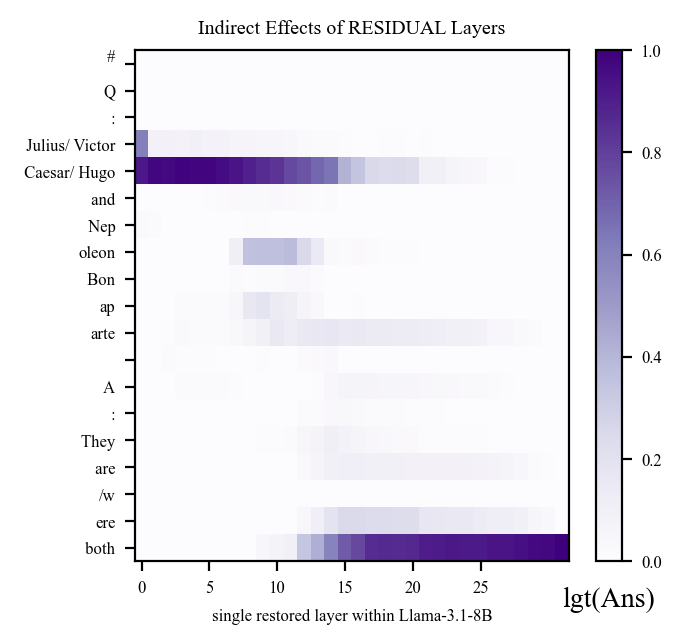

[PredictedToken(token=' explor', prob=None, logit=18.625, token_id=48539)]
2025-03-28 11:34:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0ad1dfd0>
2025-03-28 11:34:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


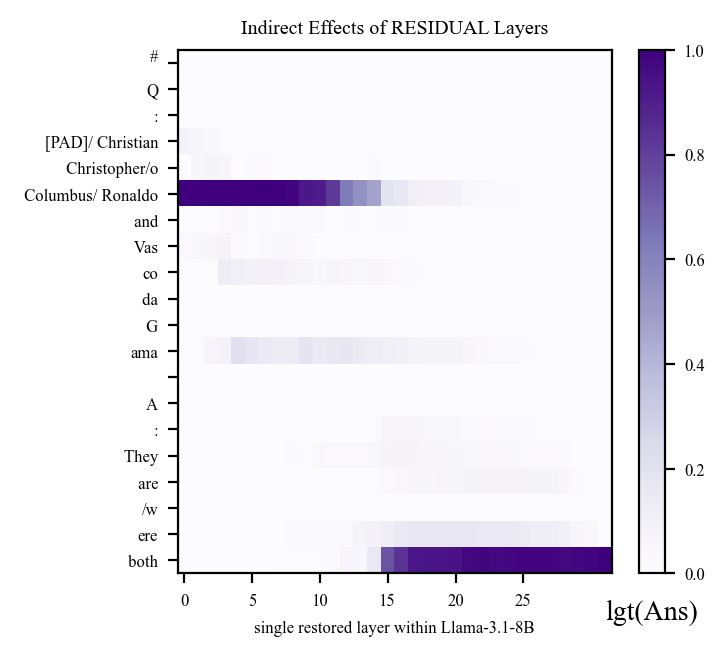

[PredictedToken(token=' blind', prob=None, logit=17.109375, token_id=18507)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0afc41d0>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


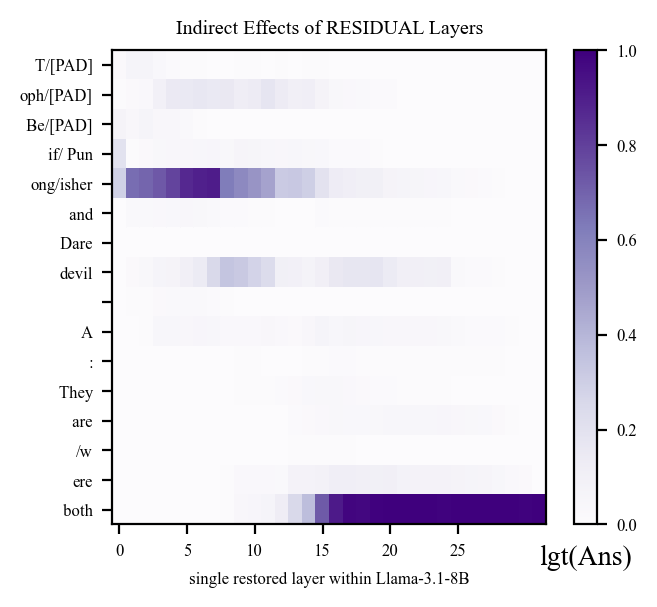

[PredictedToken(token=' ar', prob=None, logit=15.40625, token_id=802)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b0c0990>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


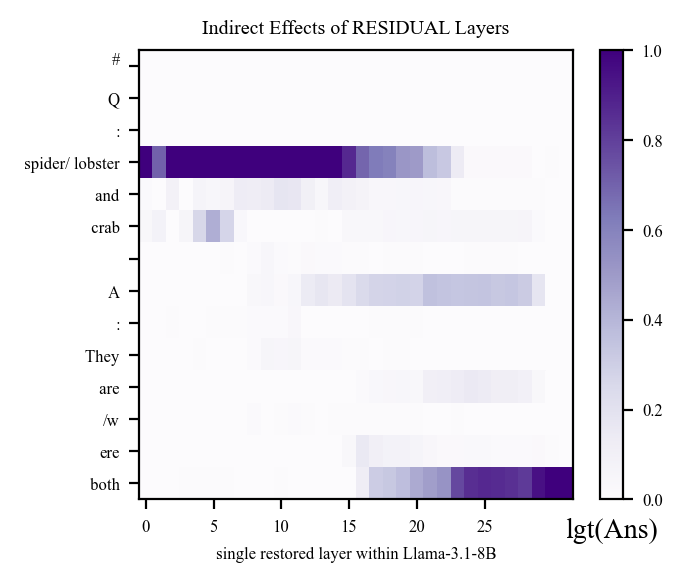

[PredictedToken(token=' ancient', prob=None, logit=17.734375, token_id=14154), PredictedToken(token=' artifacts', prob=None, logit=16.078125, token_id=36136)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b08be10>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


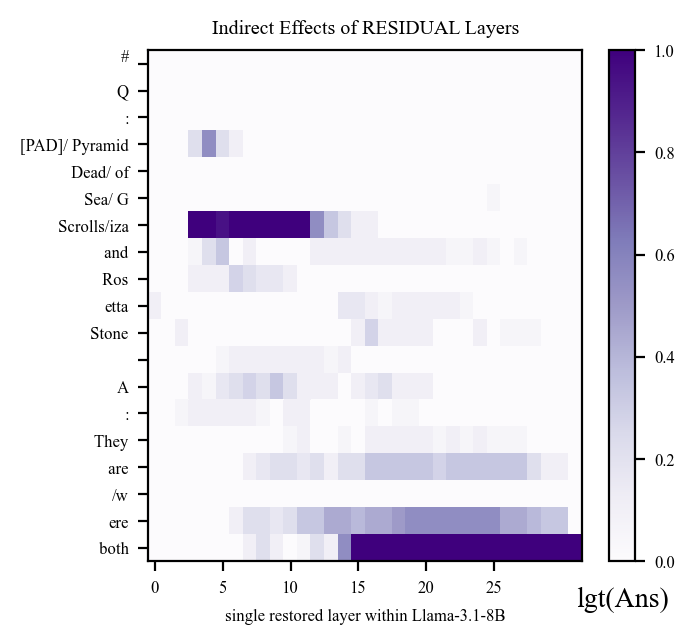

[PredictedToken(token=' Axis', prob=None, logit=16.1875, token_id=35574), PredictedToken(token=' powers', prob=None, logit=11.390625, token_id=13736), PredictedToken(token=' World', prob=None, logit=14.2265625, token_id=4435), PredictedToken(token=' War', prob=None, logit=6.8828125, token_id=5111), PredictedToken(token=' II', prob=None, logit=4.8203125, token_id=8105)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b129ed0>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


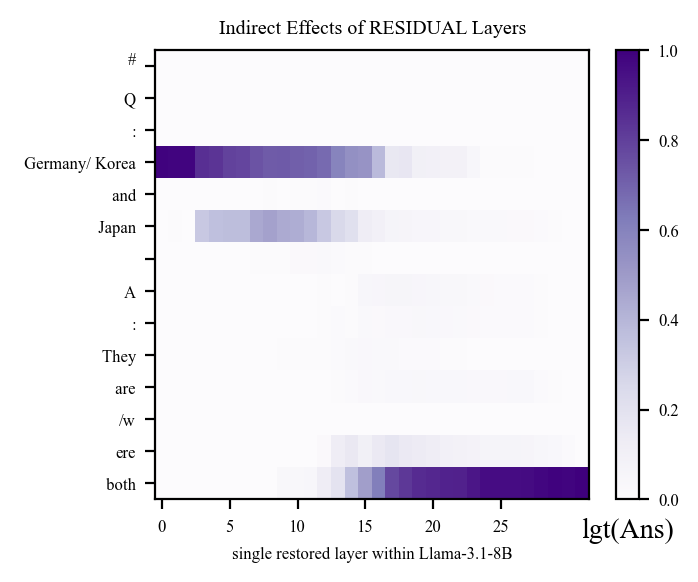

[PredictedToken(token=' in', prob=None, logit=15.6484375, token_id=304)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b36e210>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


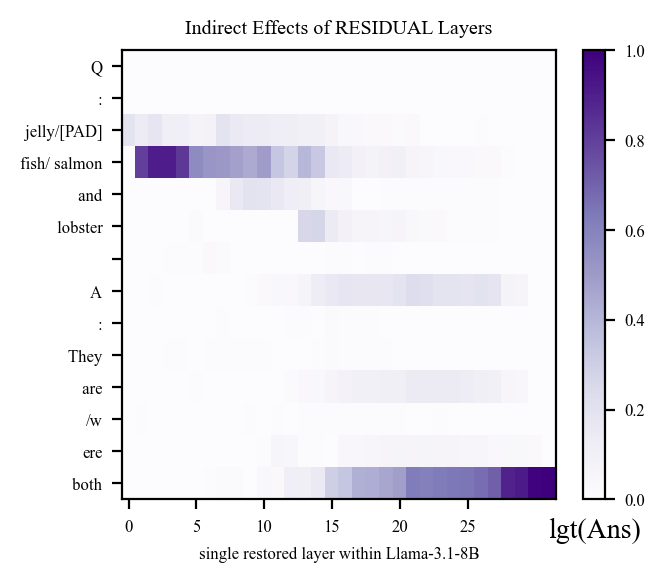

[PredictedToken(token=' mammals', prob=None, logit=16.9375, token_id=56669)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b3a9d10>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


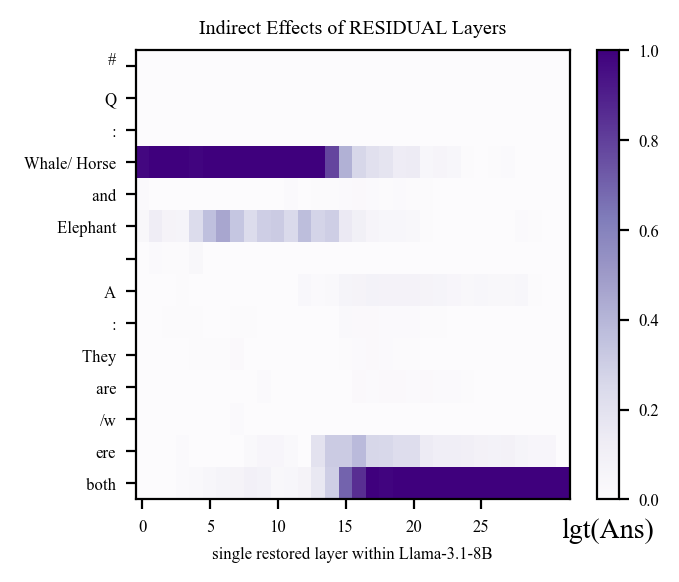

[PredictedToken(token=' apex', prob=None, logit=15.6875, token_id=72627), PredictedToken(token=' predators', prob=None, logit=14.4296875, token_id=56217)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0bcea7d0>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


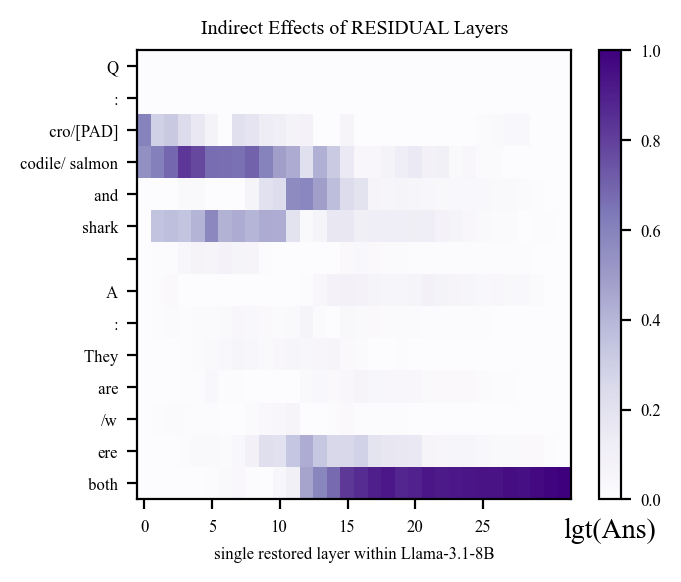

[PredictedToken(token=' flight', prob=None, logit=16.265625, token_id=11213), PredictedToken(token=' birds', prob=None, logit=13.734375, token_id=20229)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b94b250>
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:04 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


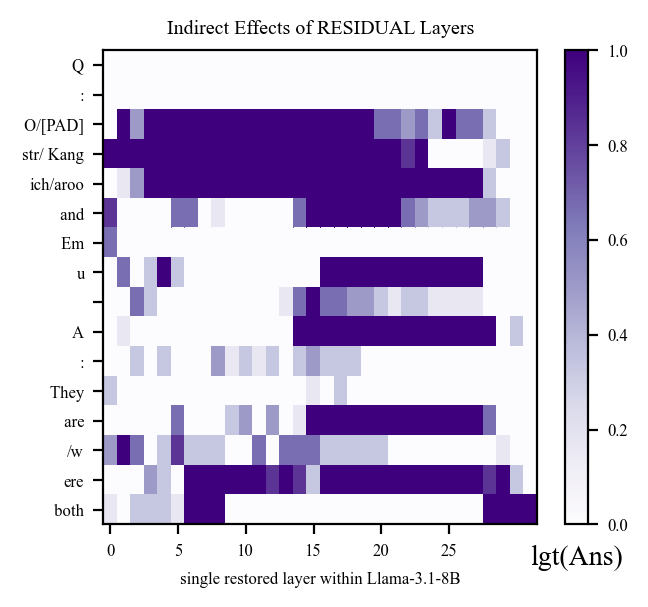

[PredictedToken(token=' X', prob=None, logit=15.5859375, token_id=1630), PredictedToken(token=' characters', prob=None, logit=11.5, token_id=5885)]
2025-03-28 11:34:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fde0b972050>
2025-03-28 11:34:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-28 11:34:05 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


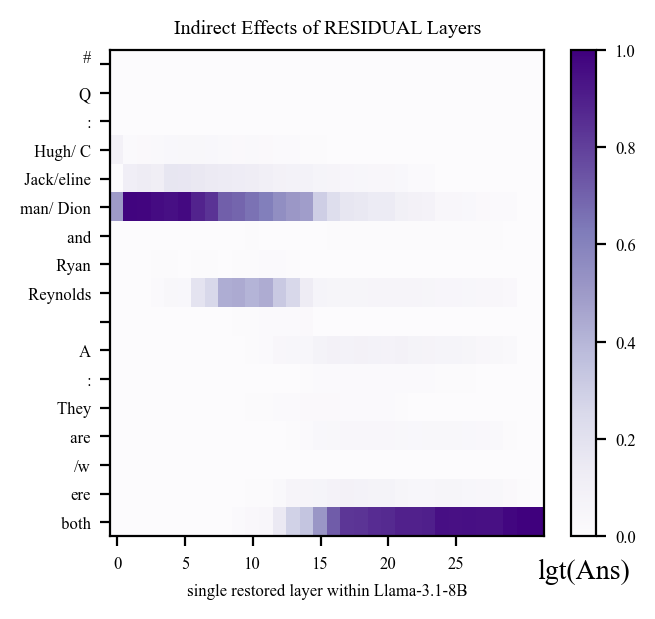

In [45]:
for idx in range(len(indirect_effects_collection)):
    trace_res = indirect_effects_collection[idx]
    print(trace_res.answer)
    # common_entity = "".join(trace_res.patch_input_toks[trace_res.subj_range[1] + 1: -8]).strip()
    # print(f"{common_entity=}")
    # token_ranges = get_token_ranges(
    #     mt, trace_res, common_entity=common_entity
    # )
    # categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)
    # aie = average_indirect_effects(
    #     categorized_effects=[categorized_effects],
    #     kind="residual",
    #     window=1,
    #     metric="logit",
    # )

    plot_trace_heatmap(
        # result=aie,
        result = trace_res,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if aie.normalized == True else None
    )

### Introspection Experiment (similar to `Patchscope`)

In [88]:
placeholder_entities = ("one", "two")
placeholder_prompt = prepare_probing_input(
    mt=mt,
    entities=placeholder_entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

In [89]:
# entities = (entities[1], entities[0])
entities

('Bruce Wayne', 'Tony Stark')

In [90]:
from src.tokens import prepare_input, find_token_range

st = mt.tokenizer.pad_token * (prompt.entity_ranges[0][0]-4) + f"\nQ: {entities[0]}"
inp = prepare_input(
    prompts = st,
    tokenizer=mt,
    return_offsets_mapping=True
)
find_token_range(
    string=st,
    substring=entities[0],
    tokenizer=mt,
    offset_mapping=inp.offset_mapping[0]
)

(206, 208)

In [91]:
prompt.entity_ranges

((206, 208), (209, 211))

In [92]:
for idx, t in list(enumerate(prompt.tokenized["input_ids"][0]))[206:]:
    print(f"{idx} => \"{mt.tokenizer.decode(t)}\"")

206 => " Bruce"
207 => " Wayne"
208 => " and"
209 => " Tony"
210 => " Stark"
211 => "
"
212 => "A"
213 => ":"
214 => " They"
215 => " are"
216 => "/w"
217 => "ere"
218 => " both"


In [93]:
for idx, t in list(enumerate(inp["input_ids"][0]))[206:]:
    print(f"{idx} => \"{mt.tokenizer.decode(t)}\"")

206 => " Bruce"
207 => " Wayne"


In [ ]:
from src.functional import get_hs, extract_rep_at_pos
from src.utils.typing import TokenizerOutput

bare_hs = [
    extract_rep_at_pos(
        mt = mt,
        input = f" {ent}",
        total_length=ent_rng[1],
        locations=[(layer, ent_rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names]
    )
    for ent, ent_rng in zip(entities, prompt.entity_ranges)
]

In [95]:
icl_hs = [
    get_hs(
        mt = mt,
        input = TokenizerOutput(data = prompt.tokenized),
        locations = [(layer, rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names],
        return_dict=True
    )
    for ent, rng in zip(entities, prompt.entity_ranges)
]

In [59]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
)
clean_pred

('Christopher Columbus', 'Vasco da Gama')


[[PredictedToken(token=' explor', prob=0.454833984375, logit=18.71875, token_id=48539),
  PredictedToken(token=' famous', prob=0.208251953125, logit=17.9375, token_id=11495),
  PredictedToken(token=' Portuguese', prob=0.0655517578125, logit=16.78125, token_id=43288),
  PredictedToken(token=' sailors', prob=0.03912353515625, logit=16.265625, token_id=69938),
  PredictedToken(token=' European', prob=0.03619384765625, logit=16.1875, token_id=7665)]]

In [97]:
## bare hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(bare_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges):
    token_pos = placeholder_range[0]
    patches.extend([
        PatchSpec(
            location = (layer, token_pos),
            # patch = ent_hs[(layer, -1)]
            patch = ent_hs[(layer, ent_range[1] - 1)]
        )
        for layer in mt.layer_names
    ])



pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id]
)

# gen = generate_with_patch(
#     mt = mt, 
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])
print(track_ans)
pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386),
  PredictedToken(token=' fictional', prob=0.09906005859375, logit=15.4921875, token_id=44682),
  PredictedToken(token=' American', prob=0.059600830078125, logit=14.984375, token_id=3778),
  PredictedToken(token=' actors', prob=0.05096435546875, logit=14.828125, token_id=20142),
  PredictedToken(token=' billionaire', prob=0.044281005859375, logit=14.6875, token_id=47794)]]

In [98]:
# patch only the last token from ICL_hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(icl_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges):
    token_pos = placeholder_range[0]
    patches.extend([
        PatchSpec(
            location = (layer, token_pos),
            # patch = ent_hs[(layer, -1)]
            patch = ent_hs[(layer, ent_range[1] - 1)]
        )
        for layer in mt.layer_names
    ])

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id]
)

# gen = generate_with_patch(
#     mt = mt, 
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])

print(track_ans)

pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386),
  PredictedToken(token=' billionaire', prob=0.1610107421875, logit=17.0, token_id=47794),
  PredictedToken(token=' fictional', prob=0.14892578125, logit=16.921875, token_id=44682),
  PredictedToken(token=' superheroes', prob=0.03704833984375, logit=15.53125, token_id=91818),
  PredictedToken(token=' the', prob=0.033203125, logit=15.421875, token_id=279)]]

In [57]:
from src.functional import predict_next_token

single_probing_prompt = "Who/what is {}? Answer: {} is a"

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = [single_probing_prompt.format(entities[0], entities[0])],
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{48539: (3345, PredictedToken(token=' explor', prob=1.4126300811767578e-05, logit=4.78515625, token_id=48539))}]


[[PredictedToken(token=' man', prob=0.0650634765625, logit=13.21875, token_id=893),
  PredictedToken(token=' fictional', prob=0.034027099609375, logit=12.5703125, token_id=44682),
  PredictedToken(token=' myth', prob=0.03375244140625, logit=12.5625, token_id=21849),
  PredictedToken(token=' hero', prob=0.0307464599609375, logit=12.46875, token_id=12084),
  PredictedToken(token=' person', prob=0.0290985107421875, logit=12.4140625, token_id=1732),
  PredictedToken(token=' famous', prob=0.028656005859375, logit=12.3984375, token_id=11495),
  PredictedToken(token=' ', prob=0.0207977294921875, logit=12.078125, token_id=220),
  PredictedToken(token=' symbol', prob=0.0206451416015625, logit=12.0703125, token_id=7891),
  PredictedToken(token=' very', prob=0.0190887451171875, logit=11.9921875, token_id=1633),
  PredictedToken(token=' white', prob=0.018218994140625, logit=11.9453125, token_id=4251),
  PredictedToken(token=' historical', prob=0.0179290771484375, logit=11.9296875, token_id=13970),

In [58]:
pred, track_ans = predict_next_token(
    mt = mt,
    inputs = single_probing_prompt.format(entities[1], entities[1]),
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{48539: (3180, PredictedToken(token=' explor', prob=1.3887882232666016e-05, logit=4.05859375, token_id=48539))}]


[[PredictedToken(token=' Portuguese', prob=0.2646484375, logit=13.9140625, token_id=43288),
  PredictedToken(token=' famous', prob=0.0341796875, logit=11.8671875, token_id=11495),
  PredictedToken(token=' port', prob=0.032623291015625, logit=11.8203125, token_id=2700),
  PredictedToken(token=' ', prob=0.0294647216796875, logit=11.71875, token_id=220),
  PredictedToken(token=' person', prob=0.0244293212890625, logit=11.53125, token_id=1732),
  PredictedToken(token=' character', prob=0.01528167724609375, logit=11.0625, token_id=3752),
  PredictedToken(token=' city', prob=0.0123748779296875, logit=10.8515625, token_id=3363),
  PredictedToken(token=' Brazilian', prob=0.0104217529296875, logit=10.6796875, token_id=36083),
  PredictedToken(token=' town', prob=0.0101776123046875, logit=10.65625, token_id=6424),
  PredictedToken(token=' name', prob=0.00986480712890625, logit=10.625, token_id=836),
  PredictedToken(token=' ship', prob=0.0095672607421875, logit=10.59375, token_id=8448),
  Predic

In [62]:
# layer = mt.layer_name_format.format(16)

# bare_hs_pair = (
#     bare_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     bare_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

# enriched_hs_pair = (
#     icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     icl_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

In [63]:
# torch.cosine_similarity(
#     bare_hs_pair[0],
#     bare_hs_pair[1],
#     dim=-1
# )

In [64]:
# torch.cosine_similarity(
#     enriched_hs_pair[0],
#     enriched_hs_pair[1],
#     dim=-1
# )

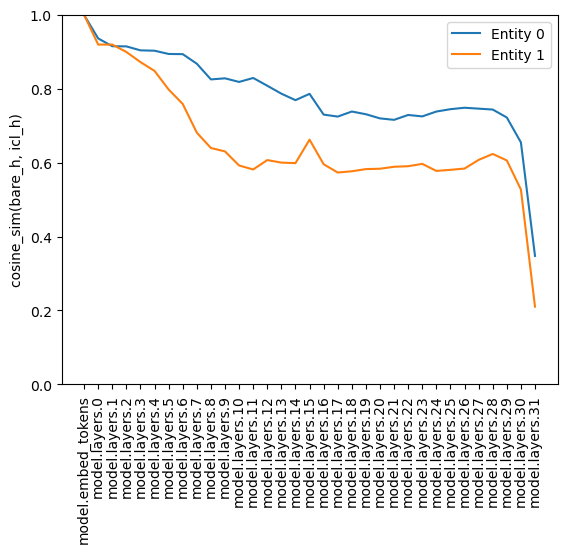

In [65]:
similarity_0 = []
similarity_1 = []

for layer in [mt.embedder_name] + mt.layer_names:
    entity_pos_0 = prompt.entity_ranges[0][1] - 1
    sim_0 = torch.cosine_similarity(
        bare_hs[0][(layer, entity_pos_0)], icl_hs[0][(layer, entity_pos_0)], dim=-1
    )

    similarity_0.append(sim_0.item())

    entity_pos_1 = prompt.entity_ranges[1][1] - 1
    sim_1 = torch.cosine_similarity(
        bare_hs[1][(layer, entity_pos_1)], icl_hs[1][(layer, entity_pos_1)], dim=-1
    )

    similarity_1.append(sim_1.item())

# print(f"{layer}: {sim_0.item()=}, {sim_1.item()=}")

from matplotlib import pyplot as plt
plt.plot(similarity_0, label="Entity 0")
plt.plot(similarity_1, label="Entity 1")

plt.legend()
plt.ylim(0, 1)
plt.ylabel("cosine_sim(bare_h, icl_h)")

plt.xticks(range(mt.n_layer + 1), [mt.embedder_name] + mt.layer_names, rotation=90)
plt.show()
    

### Use the corner as introspection point

2025-02-10 13:24:34 src.operators.estimators INFO     What is the nationality of X? Answer:  |>> self.placeholder_pos=7 | self.inputs['input_ids'].shape=torch.Size([1, 11])
[' British', ' American', ' French', ' German', ' Italian', ' Spanish', ' Russian', ' Chinese', ' Japanese', ' Indian']
2025-02-10 13:24:34 src.operators.estimators INFO     Initialized to [PredictedToken(token='1', prob=0.486572265625, logit=20.109375, token_id=16), PredictedToken(token='2', prob=0.168212890625, logit=19.046875, token_id=17), PredictedToken(token='3', prob=0.1036376953125, logit=18.5625, token_id=18), PredictedToken(token='10', prob=0.0445556640625, logit=17.71875, token_id=605), PredictedToken(token='4', prob=0.02423095703125, logit=17.109375, token_id=19)]


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


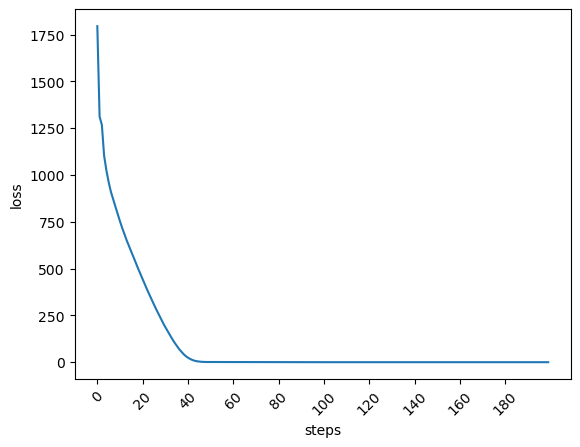

2025-02-10 13:24:52 src.operators.estimators INFO     Tuned to: [PredictedToken(token=' Japanese', prob=0.08056640625, logit=20.0, token_id=11002), PredictedToken(token=' Russian', prob=0.08056640625, logit=20.0, token_id=8690), PredictedToken(token=' Chinese', prob=0.08056640625, logit=20.0, token_id=8620), PredictedToken(token=' German', prob=0.07928466796875, logit=19.984375, token_id=6063), PredictedToken(token=' American', prob=0.07928466796875, logit=19.984375, token_id=3778)]


In [37]:
from src.operators.estimators import CornerEstimator

estimator = CornerEstimator(
    mt = mt, layer_name=mt.layer_names[2], verbose=True,
    prompt = "What is the nationality of X? Answer: ",
    placeholder = "X",
)

# with open(
#     os.path.join(
#         env_utils.DEFAULT_DATA_DIR, 
#         "object_mappings", 
#         "professions.json"
#         # "colors.json"
#     ), "r"
# ) as f:
#     objects = json.load(f)
# # objects = [f" {c}" for c in objects]
# objects = [" Christian", " Muslim", " Hindu", " Buddhist", " Sikh", " Jewish", " Atheist", " Agnostic", " Deist", " Pagan"]
# objects = [" red", " blue", " green", " yellow", " orange", " purple", " pink", " black", " white", " grey"]
objects = [" British", " American", " French", " German", " Italian", " Spanish", " Russian", " Chinese", " Japanese", " Indian"]

token_indices = (
    mt.tokenizer(
        objects,
        add_special_tokens=False,
        return_tensors="pt",
        padding=True,
        padding_side="right",
    )
    .input_ids[:, 0]
    .tolist()
)
print([mt.tokenizer.decode(t) for t in token_indices])

corner = estimator.estimate(
    class_indices=token_indices, 
    n_steps=200, 
    # space="prob",
    target_val=20,
    # concept_subspace_regularizer=0.1
    weight_decay=5e-4
)

In [66]:
placeholder_prompt.entity_ranges

((206, 207), (208, 209))

In [67]:
entities

('Rafael Nadal', 'Javier Bardem')

In [68]:
corner_pos = placeholder_prompt.entity_ranges[1][0]
entity_pos = placeholder_prompt.entity_ranges[0][0]

# corner_pos = placeholder_prompt.entity_ranges[0][0]
# entity_pos = placeholder_prompt.entity_ranges[1][0]

corner_patch = []
for layer in mt.layer_names:
    corner_patch.append(PatchSpec(
        location=(layer, corner_pos),
        patch=corner.corner
    ))
    corner_patch.append(PatchSpec(
        location=(layer, entity_pos),
        patch=icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)]
        # patch = corner.corner
    ))


pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches = corner_patch,
    k = 20,
    token_of_interest=[token_indices]
)

pred

[[PredictedToken(token=' tennis', prob=0.51953125, logit=17.546875, token_id=32515),
  PredictedToken(token=' professional', prob=0.2132568359375, logit=16.65625, token_id=6721),
  PredictedToken(token=' athletes', prob=0.0212860107421875, logit=14.3515625, token_id=23579),
  PredictedToken(token=' Spanish', prob=0.0201416015625, logit=14.296875, token_id=15506),
  PredictedToken(token=' world', prob=0.016448974609375, logit=14.09375, token_id=1917),
  PredictedToken(token=' ranked', prob=0.0161895751953125, logit=14.078125, token_id=21682),
  PredictedToken(token=' active', prob=0.0141754150390625, logit=13.9453125, token_id=4642),
  PredictedToken(token=' top', prob=0.011749267578125, logit=13.7578125, token_id=1948),
  PredictedToken(token=' famous', prob=0.0088043212890625, logit=13.46875, token_id=11495),
  PredictedToken(token=' number', prob=0.00873565673828125, logit=13.4609375, token_id=1396),
  PredictedToken(token=' players', prob=0.007648468017578125, logit=13.328125, token

In [71]:
from src.functional import logit_lens

logit_lens(
    mt = mt,
    h = bare_hs[0][(mt.layer_names[25], prompt.entity_ranges[0][1] - 1)],
    interested_tokens=token_indices
)

([PredictedToken(token=' Rafael', prob=0.06689453125, logit=10.5859375, token_id=55500),
  PredictedToken(token=' ATP', prob=0.0643310546875, logit=10.546875, token_id=67656),
  PredictedToken(token=' Roland', prob=0.028564453125, logit=9.734375, token_id=58906),
  PredictedToken(token=' tennis', prob=0.021392822265625, logit=9.4453125, token_id=32515),
  PredictedToken(token=' Wimbledon', prob=0.0208892822265625, logit=9.421875, token_id=91257)],
 {15506: (36,
   PredictedToken(token=' Spanish', prob=0.0016050338745117188, logit=6.85546875, token_id=15506)),
  8753: (167,
   PredictedToken(token=' French', prob=0.00035953521728515625, logit=5.359375, token_id=8753)),
  7904: (1637,
   PredictedToken(token=' Indian', prob=5.632638931274414e-05, logit=3.505859375, token_id=7904)),
  6063: (3358,
   PredictedToken(token=' German', prob=3.0875205993652344e-05, logit=2.904296875, token_id=6063)),
  15155: (4648,
   PredictedToken(token=' Italian', prob=2.3066997528076172e-05, logit=2.61328